In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Data + DataPipline

In [3]:
ds, test_ds = tfds.load('mnist', split=['train', 'test'])

ds = ds.map(lambda feature_dict: (feature_dict['image'], feature_dict['label']))
ds = ds.map(lambda image, label: (tf.reshape(image, [-1]), label))
ds = ds.map(lambda image, label: (tf.cast(image/128, tf.float32)-1, label))
ds = ds.map(lambda image, label: (image, tf.one_hot(label, 10)))
ds = ds.shuffle(1024).batch(32)
ds = ds.prefetch(4)

test_ds = test_ds.map(lambda feature_dict: (feature_dict['image'], feature_dict['label']))
test_ds = test_ds.map(lambda image, label: (tf.reshape(image, [-1]), label))
test_ds = test_ds.map(lambda image, label: (tf.cast(image/128, tf.float32)-1, label))
test_ds = test_ds.map(lambda image, label: (image, tf.one_hot(label, 10)))
test_ds = test_ds.shuffle(1024).batch(32)
test_ds = test_ds.prefetch(4)

# Model creation

In [4]:
class MLP_Model(tf.keras.Model):
    def __init__(self, layersize, output_size=10):
        super().__init__()
        self.mlp_layers = []
        for size in layersize:
            self.mlp_layers.append(tf.keras.layers.Dense(size, activation='sigmoid'))
        self.mlp_layers.append(tf.keras.layers.Dense(output_size, activation='softmax'))

    def call(self, x):
        for layer in self.mlp_layers:
            x = layer(x)
        return x

# Training

In [5]:
model = MLP_Model([256,256])
cce = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.1)
ds = ds

# Initialize lists to store training and test loss and accuracy
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

# Initialize the accuracy metrics
train_accuracy_metric = tf.keras.metrics.Accuracy()
test_accuracy_metric = tf.keras.metrics.Accuracy()

# Training loop
num_epochs = 10  # You can adjust this based on your needs

for epoch in range(num_epochs):
    # Training
    total_train_loss = 0.0
    train_accuracy_metric.reset_states()

    for inputs, labels in ds:
        with tf.GradientTape() as tape:
            outputs = model(inputs)
            train_loss = cce(labels, outputs)

        gradients = tape.gradient(train_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        total_train_loss += train_loss.numpy()
        train_accuracy_metric.update_state(tf.argmax(labels, axis=1), tf.argmax(outputs, axis=1))

    average_train_loss = total_train_loss / len(ds)
    train_accuracy = train_accuracy_metric.result().numpy()

    # Testing
    total_test_loss = 0.0
    test_accuracy_metric.reset_states()

    for test_inputs, test_labels in test_ds:
        test_outputs = model(test_inputs)
        test_loss = cce(test_labels, test_outputs)

        total_test_loss += test_loss.numpy()
        test_accuracy_metric.update_state(tf.argmax(test_labels, axis=1), tf.argmax(test_outputs, axis=1))

    average_test_loss = total_test_loss / len(test_ds)
    test_accuracy = test_accuracy_metric.result().numpy()

    # Print or log the values
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # Store values for plotting
    train_loss_list.append(average_train_loss)
    train_accuracy_list.append(train_accuracy)
    test_loss_list.append(average_test_loss)
    test_accuracy_list.append(test_accuracy)

Epoch 1/10, Train Loss: 0.6091, Train Accuracy: 0.8169, Test Loss: 0.3193, Test Accuracy: 0.9043
Epoch 2/10, Train Loss: 0.2823, Train Accuracy: 0.9165, Test Loss: 0.2396, Test Accuracy: 0.9279
Epoch 3/10, Train Loss: 0.2201, Train Accuracy: 0.9348, Test Loss: 0.1928, Test Accuracy: 0.9452
Epoch 4/10, Train Loss: 0.1774, Train Accuracy: 0.9484, Test Loss: 0.1595, Test Accuracy: 0.9519
Epoch 5/10, Train Loss: 0.1468, Train Accuracy: 0.9570, Test Loss: 0.1381, Test Accuracy: 0.9589
Epoch 6/10, Train Loss: 0.1256, Train Accuracy: 0.9631, Test Loss: 0.1178, Test Accuracy: 0.9648
Epoch 7/10, Train Loss: 0.1088, Train Accuracy: 0.9682, Test Loss: 0.1121, Test Accuracy: 0.9669
Epoch 8/10, Train Loss: 0.0959, Train Accuracy: 0.9718, Test Loss: 0.1020, Test Accuracy: 0.9681
Epoch 9/10, Train Loss: 0.0850, Train Accuracy: 0.9749, Test Loss: 0.0961, Test Accuracy: 0.9713
Epoch 10/10, Train Loss: 0.0756, Train Accuracy: 0.9783, Test Loss: 0.0902, Test Accuracy: 0.9723


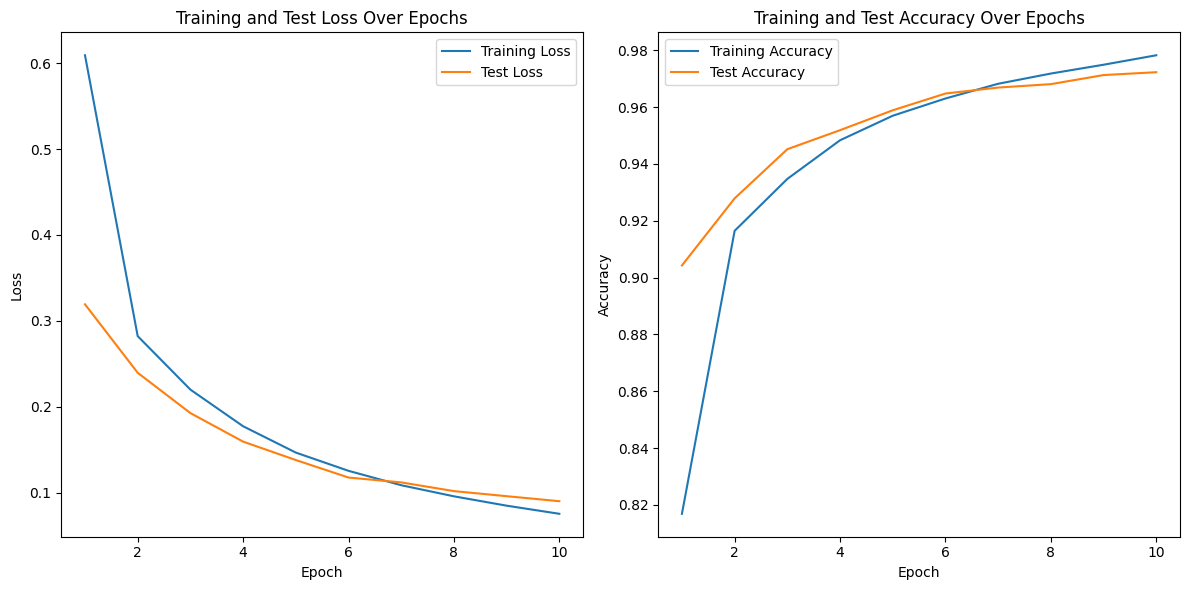

In [6]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 6))

# Plot Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_loss_list, label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracy_list, label='Test Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()